YOLOv8: [0,372,364,785]
YOLOv8: [522,377,1100,830]
YOLOv8: [213,363,482,554]
YOLOv8: [1061,378,1235,512]
YOLOv8: [422,380,724,583]
YOLOv8: [1403,179,1689,1063]
YOLOv8: [1289,254,1507,812]
YOLOv8: [1737,182,1919,1069]
YOLOv8: [1075,272,1250,483]
YOLOv8: [465,354,624,445]
YOLOv8: [1676,248,1810,497]
YOLOv8: [1076,270,1253,503]
YOLOv8: [696,366,747,420]
SSD300: [477,369,1078,823]
SSD300: [205,370,489,555]
SSD300: [1380,240,1705,1052]
SSD300: [461,385,720,562]
SSD300: [0,379,356,813]
SSD300: [1048,369,1233,504]
YOLOv8: [0,371,364,782]
YOLOv8: [506,382,1098,851]
YOLOv8: [1058,378,1233,512]
YOLOv8: [212,363,481,554]
YOLOv8: [1389,180,1664,1066]
YOLOv8: [421,379,714,585]
YOLOv8: [1296,254,1504,815]
YOLOv8: [1743,185,1919,1071]
YOLOv8: [465,353,626,445]
YOLOv8: [1076,271,1248,482]
YOLOv8: [1678,247,1810,501]
YOLOv8: [1553,465,1749,774]
YOLOv8: [1076,270,1251,503]
YOLOv8: [693,366,744,416]
SSD300: [462,366,1099,810]
SSD300: [183,369,494,560]
SSD300: [1393,251,1686,1047]
SSD300: [453,387,682,569

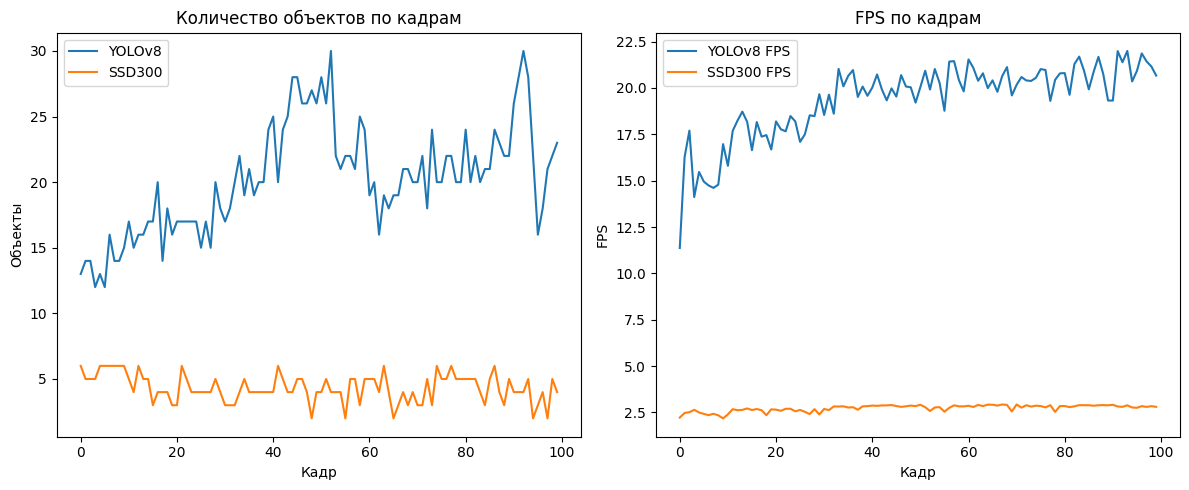

In [11]:
import cv2, time, torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision.models.detection import ssd300_vgg16
from torchvision.transforms import functional as F

# Загрузка моделей
yolo = YOLO("yolov8n.pt")
ssd = ssd300_vgg16(pretrained=True).eval()

cap = cv2.VideoCapture("input/1.mp4")

yolo_counts, ssd_counts = [], []
yolo_times, ssd_times = [], []
yolo_total, ssd_total = 0, 0
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_idx >= 100: break
    frame_idx += 1

    # YOLOv8
    t0 = time.time()
    yolo_result = yolo(frame, verbose=False)[0]
    yolo_boxes = yolo_result.boxes.xyxy.cpu().numpy()
    yolo_total += len(yolo_boxes)
    yolo_counts.append(len(yolo_boxes))
    yolo_times.append(time.time() - t0)
    for box in yolo_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        print(f"YOLOv8: [{x1},{y1},{x2},{y2}]")

    # SSD300
    t1 = time.time()
    img_tensor = F.to_tensor(frame).unsqueeze(0)
    with torch.no_grad():
        ssd_result = ssd(img_tensor)[0]
    ssd_boxes = ssd_result['boxes']
    ssd_scores = ssd_result['scores']
    ssd_filtered = ssd_boxes[ssd_scores > 0.5]
    ssd_total += len(ssd_filtered)
    ssd_counts.append(len(ssd_filtered))
    ssd_times.append(time.time() - t1)
    for box in ssd_filtered:
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255,0,0), 2)
        print(f"SSD300: [{x1},{y1},{x2},{y2}]")

    cv2.imshow("Detection (YOLO=зелёный, SSD=синий)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Итоговые значения
print(f"Обработано кадров: {frame_idx}")
print(f"YOLOv8: всего объектов {yolo_total}, среднее на кадр {np.mean(yolo_counts):.2f}, средний FPS {np.mean([1/t for t in yolo_times]):.2f}")
print(f"SSD300: всего объектов {ssd_total}, среднее на кадр {np.mean(ssd_counts):.2f}, средний FPS {np.mean([1/t for t in ssd_times]):.2f}")

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(yolo_counts, label="YOLOv8")
plt.plot(ssd_counts, label="SSD300")
plt.title("Количество объектов по кадрам")
plt.xlabel("Кадр")
plt.ylabel("Объекты")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([1/t for t in yolo_times], label="YOLOv8 FPS")
plt.plot([1/t for t in ssd_times], label="SSD300 FPS")
plt.title("FPS по кадрам")
plt.xlabel("Кадр")
plt.ylabel("FPS")
plt.legend()

plt.tight_layout()
plt.show()



YOLOv8 метрики:
- Всего объектов: 2022
- Среднее объектов/кадр: 20.22
- Медиана объектов/кадр: 20.00
- Мин/Макс объектов: 12 / 30
- Средний FPS: 18.72
- Медианный FPS: 19.28
- Ст. отклонение FPS: 2.08
- Коэф. вариации FPS: 0.11
- Пустые кадры: 0.00%
- Насыщенные кадры: 100.00%
- Стабильность FPS: 95.00%

SSD300 метрики:
- Всего объектов: 431
- Среднее объектов/кадр: 4.31
- Медиана объектов/кадр: 4.00
- Мин/Макс объектов: 2 / 6
- Средний FPS: 2.70
- Медианный FPS: 2.69
- Ст. отклонение FPS: 0.15
- Коэф. вариации FPS: 0.05
- Пустые кадры: 0.00%
- Насыщенные кадры: 20.00%
- Стабильность FPS: 0.00%

Обработано кадров: 100
Выходное видео сохранено: comparison_output.mp4


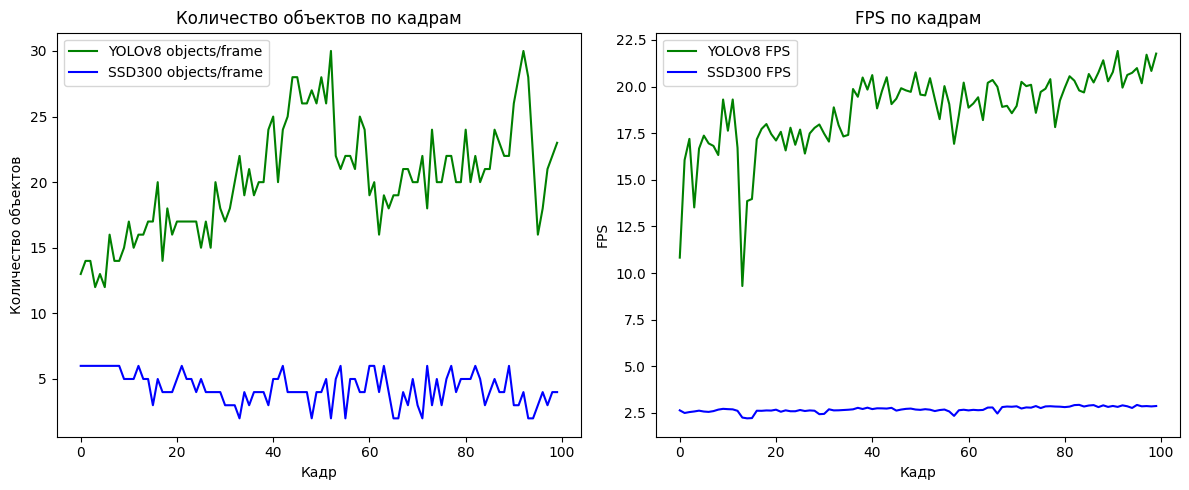

In [12]:
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.transforms import functional as F

# =========================
# Настройки
# =========================
VIDEO_PATH = "input/1.mp4"   # замените на свой путь
MAX_FRAMES = 100                # лимит кадров для быстрого сравнения
YOLO_SCORE_THRESHOLD = 0.25     # порог для YOLO
SSD_SCORE_THRESHOLD = 0.5       # порог для SSD
DISPLAY_WINDOW_NAME = "Detection (YOLO=green, SSD=blue)"

# Порог насыщенности и стабильности
YOLO_SAT_THRESHOLD = 10  # насыщенные кадры по количеству объектов
SSD_SAT_THRESHOLD = 5
YOLO_STABLE_FPS = 15     # стабильные кадры по FPS
SSD_STABLE_FPS = 5

# Выходное видео
OUTPUT_VIDEO_PATH = "comparison_output.mp4"
OUTPUT_FPS = 25  # целевой FPS для сохранения видео

# =========================
# Утилиты
# =========================
def put_text(img, text, org, color=(255, 255, 255)):
    cv2.putText(img, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

def compute_metrics(counts, times, sat_threshold, stable_fps_threshold):
    counts_arr = np.array(counts)
    fps_arr = np.array([1.0 / t if t > 0 else 0.0 for t in times])

    metrics = {
        "total_objects": int(np.sum(counts_arr)),
        "mean_objects": float(np.mean(counts_arr)),
        "median_objects": float(np.median(counts_arr)),
        "min_objects": int(np.min(counts_arr)) if len(counts_arr) else 0,
        "max_objects": int(np.max(counts_arr)) if len(counts_arr) else 0,
        "mean_fps": float(np.mean(fps_arr)),
        "median_fps": float(np.median(fps_arr)),
        "std_fps": float(np.std(fps_arr)),
        "cv_fps": float(np.std(fps_arr) / np.mean(fps_arr)) if np.mean(fps_arr) > 0 else float("nan"),
        "empty_frames_pct": float(np.sum(counts_arr == 0) / len(counts_arr) * 100) if len(counts_arr) else 0.0,
        "saturated_frames_pct": float(np.sum(counts_arr > sat_threshold) / len(counts_arr) * 100) if len(counts_arr) else 0.0,
        "stable_fps_pct": float(np.sum(fps_arr > stable_fps_threshold) / len(fps_arr) * 100) if len(fps_arr) else 0.0,
    }
    return metrics, fps_arr

def print_metrics(name, metrics):
    print(f"\n{name} метрики:")
    print(f"- Всего объектов: {metrics['total_objects']}")
    print(f"- Среднее объектов/кадр: {metrics['mean_objects']:.2f}")
    print(f"- Медиана объектов/кадр: {metrics['median_objects']:.2f}")
    print(f"- Мин/Макс объектов: {metrics['min_objects']} / {metrics['max_objects']}")
    print(f"- Средний FPS: {metrics['mean_fps']:.2f}")
    print(f"- Медианный FPS: {metrics['median_fps']:.2f}")
    print(f"- Ст. отклонение FPS: {metrics['std_fps']:.2f}")
    print(f"- Коэф. вариации FPS: {metrics['cv_fps']:.2f}")
    print(f"- Пустые кадры: {metrics['empty_frames_pct']:.2f}%")
    print(f"- Насыщенные кадры: {metrics['saturated_frames_pct']:.2f}%")
    print(f"- Стабильность FPS: {metrics['stable_fps_pct']:.2f}%")

# =========================
# Загрузка моделей
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo = YOLO("yolov8n.pt")  # быстрая версия
ssd = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT).eval()

# =========================
# Видео и сохранение результата
# =========================
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Не удалось открыть видео: {VIDEO_PATH}")

ret, sample_frame = cap.read()
if not ret:
    raise RuntimeError("Не удалось прочитать первый кадр.")

height, width = sample_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, OUTPUT_FPS, (width, height))

# =========================
# Списки для метрик
# =========================
yolo_counts, ssd_counts = [], []
yolo_times, ssd_times = [], []

frame_idx = 0

# =========================
# Основной цикл обработки
# =========================
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # вернемся к началу
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_idx >= MAX_FRAMES:
        break
    frame_idx += 1

    # ---------- YOLOv8 ----------
    t0 = time.time()
    yolo_result = yolo(frame, verbose=False, conf=YOLO_SCORE_THRESHOLD)[0]
    yolo_boxes = yolo_result.boxes.xyxy.cpu().numpy() if yolo_result.boxes is not None else np.empty((0, 4))
    yolo_counts.append(len(yolo_boxes))
    yolo_times.append(time.time() - t0)

    # Визуализация YOLO + вывод координат
    for box in yolo_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        put_text(frame, "YOLO", (x1, max(y1 - 5, 0)), (0, 255, 0))
        # Координаты в консоль при необходимости:
        # print(f"YOLOv8: [{x1},{y1},{x2},{y2}]")

    # ---------- SSD300 ----------
    t1 = time.time()
    img_tensor = F.to_tensor(frame).unsqueeze(0)
    with torch.no_grad():
        ssd_result = ssd(img_tensor)[0]
    ssd_boxes = ssd_result["boxes"]
    ssd_scores = ssd_result["scores"]
    keep = ssd_scores > SSD_SCORE_THRESHOLD
    ssd_filtered = ssd_boxes[keep]
    ssd_counts.append(int(len(ssd_filtered)))
    ssd_times.append(time.time() - t1)

    # Визуализация SSD + вывод координат
    for box in ssd_filtered:
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        put_text(frame, "SSD", (x1, max(y1 - 5, 0)), (255, 0, 0))
        # Координаты в консоль при необходимости:
        # print(f"SSD300: [{x1},{y1},{x2},{y2}]")

    # ---------- Оверлеи статистики на кадре ----------
    put_text(frame, f"Frame: {frame_idx}", (10, 25))
    put_text(frame, f"YOLO count: {yolo_counts[-1]}", (10, 55), (0, 255, 0))
    put_text(frame, f"SSD count: {ssd_counts[-1]}", (10, 85), (255, 0, 0))

    # Сохранение кадра в выходное видео
    writer.write(frame)

    # Показ в реальном времени
    cv2.imshow(DISPLAY_WINDOW_NAME, frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

# =========================
# Метрики и графики
# =========================
yolo_metrics, yolo_fps_series = compute_metrics(yolo_counts, yolo_times, YOLO_SAT_THRESHOLD, YOLO_STABLE_FPS)
ssd_metrics, ssd_fps_series = compute_metrics(ssd_counts, ssd_times, SSD_SAT_THRESHOLD, SSD_STABLE_FPS)

# Вывод метрик
print_metrics("YOLOv8", yolo_metrics)
print_metrics("SSD300", ssd_metrics)

print(f"\nОбработано кадров: {frame_idx}")
print(f"Выходное видео сохранено: {OUTPUT_VIDEO_PATH}")

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(yolo_counts, label="YOLOv8 objects/frame", color="green")
plt.plot(ssd_counts, label="SSD300 objects/frame", color="blue")
plt.title("Количество объектов по кадрам")
plt.xlabel("Кадр")
plt.ylabel("Количество объектов")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(yolo_fps_series, label="YOLOv8 FPS", color="green")
plt.plot(ssd_fps_series, label="SSD300 FPS", color="blue")
plt.title("FPS по кадрам")
plt.xlabel("Кадр")
plt.ylabel("FPS")
plt.legend()

plt.tight_layout()
plt.show()



YOLOv8 метрики:
- Всего объектов: 982
- Среднее объектов/кадр: 9.82
- Медиана объектов/кадр: 10.00
- Мин/Макс объектов: 4 / 20
- Средний FPS: 18.84
- Медианный FPS: 19.44
- Ст. отклонение FPS: 1.90
- Коэф. вариации FPS: 0.10
- Пустые кадры: 0.00%
- Насыщенные кадры: 37.00%
- Стабильность FPS: 97.00%

SSD300 метрики:
- Всего объектов: 199
- Среднее объектов/кадр: 1.99
- Медиана объектов/кадр: 2.00
- Мин/Макс объектов: 0 / 5
- Средний FPS: 2.74
- Медианный FPS: 2.79
- Ст. отклонение FPS: 0.14
- Коэф. вариации FPS: 0.05
- Пустые кадры: 11.00%
- Насыщенные кадры: 0.00%
- Стабильность FPS: 0.00%

Обработано кадров: 100
Выходное видео сохранено: comparison_output_2.mp4


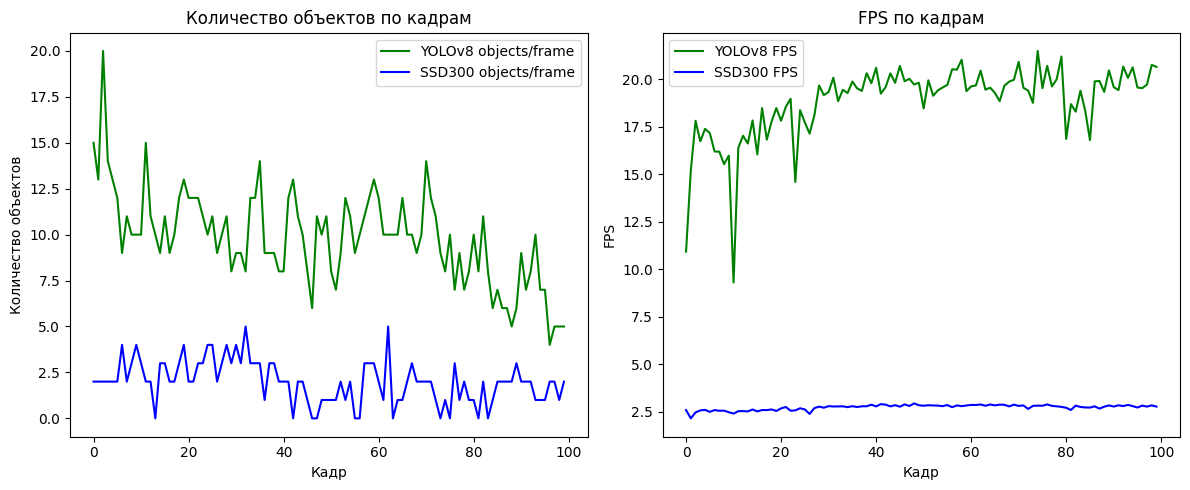

In [13]:
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.transforms import functional as F

# =========================
# Настройки
# =========================
VIDEO_PATH = "input/2.mp4"   # замените на свой путь
MAX_FRAMES = 100                # лимит кадров для быстрого сравнения
YOLO_SCORE_THRESHOLD = 0.25     # порог для YOLO
SSD_SCORE_THRESHOLD = 0.5       # порог для SSD
DISPLAY_WINDOW_NAME = "Detection (YOLO=green, SSD=blue)"

# Порог насыщенности и стабильности
YOLO_SAT_THRESHOLD = 10  # насыщенные кадры по количеству объектов
SSD_SAT_THRESHOLD = 5
YOLO_STABLE_FPS = 15     # стабильные кадры по FPS
SSD_STABLE_FPS = 5

# Выходное видео
OUTPUT_VIDEO_PATH = "comparison_output_2.mp4"
OUTPUT_FPS = 25  # целевой FPS для сохранения видео

# =========================
# Утилиты
# =========================
def put_text(img, text, org, color=(255, 255, 255)):
    cv2.putText(img, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

def compute_metrics(counts, times, sat_threshold, stable_fps_threshold):
    counts_arr = np.array(counts)
    fps_arr = np.array([1.0 / t if t > 0 else 0.0 for t in times])

    metrics = {
        "total_objects": int(np.sum(counts_arr)),
        "mean_objects": float(np.mean(counts_arr)),
        "median_objects": float(np.median(counts_arr)),
        "min_objects": int(np.min(counts_arr)) if len(counts_arr) else 0,
        "max_objects": int(np.max(counts_arr)) if len(counts_arr) else 0,
        "mean_fps": float(np.mean(fps_arr)),
        "median_fps": float(np.median(fps_arr)),
        "std_fps": float(np.std(fps_arr)),
        "cv_fps": float(np.std(fps_arr) / np.mean(fps_arr)) if np.mean(fps_arr) > 0 else float("nan"),
        "empty_frames_pct": float(np.sum(counts_arr == 0) / len(counts_arr) * 100) if len(counts_arr) else 0.0,
        "saturated_frames_pct": float(np.sum(counts_arr > sat_threshold) / len(counts_arr) * 100) if len(counts_arr) else 0.0,
        "stable_fps_pct": float(np.sum(fps_arr > stable_fps_threshold) / len(fps_arr) * 100) if len(fps_arr) else 0.0,
    }
    return metrics, fps_arr

def print_metrics(name, metrics):
    print(f"\n{name} метрики:")
    print(f"- Всего объектов: {metrics['total_objects']}")
    print(f"- Среднее объектов/кадр: {metrics['mean_objects']:.2f}")
    print(f"- Медиана объектов/кадр: {metrics['median_objects']:.2f}")
    print(f"- Мин/Макс объектов: {metrics['min_objects']} / {metrics['max_objects']}")
    print(f"- Средний FPS: {metrics['mean_fps']:.2f}")
    print(f"- Медианный FPS: {metrics['median_fps']:.2f}")
    print(f"- Ст. отклонение FPS: {metrics['std_fps']:.2f}")
    print(f"- Коэф. вариации FPS: {metrics['cv_fps']:.2f}")
    print(f"- Пустые кадры: {metrics['empty_frames_pct']:.2f}%")
    print(f"- Насыщенные кадры: {metrics['saturated_frames_pct']:.2f}%")
    print(f"- Стабильность FPS: {metrics['stable_fps_pct']:.2f}%")

# =========================
# Загрузка моделей
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo = YOLO("yolov8n.pt")  # быстрая версия
ssd = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT).eval()

# =========================
# Видео и сохранение результата
# =========================
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Не удалось открыть видео: {VIDEO_PATH}")

ret, sample_frame = cap.read()
if not ret:
    raise RuntimeError("Не удалось прочитать первый кадр.")

height, width = sample_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, OUTPUT_FPS, (width, height))

# =========================
# Списки для метрик
# =========================
yolo_counts, ssd_counts = [], []
yolo_times, ssd_times = [], []

frame_idx = 0

# =========================
# Основной цикл обработки
# =========================
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # вернемся к началу
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_idx >= MAX_FRAMES:
        break
    frame_idx += 1

    # ---------- YOLOv8 ----------
    t0 = time.time()
    yolo_result = yolo(frame, verbose=False, conf=YOLO_SCORE_THRESHOLD)[0]
    yolo_boxes = yolo_result.boxes.xyxy.cpu().numpy() if yolo_result.boxes is not None else np.empty((0, 4))
    yolo_counts.append(len(yolo_boxes))
    yolo_times.append(time.time() - t0)

    # Визуализация YOLO + вывод координат
    for box in yolo_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        put_text(frame, "YOLO", (x1, max(y1 - 5, 0)), (0, 255, 0))
        # Координаты в консоль при необходимости:
        # print(f"YOLOv8: [{x1},{y1},{x2},{y2}]")

    # ---------- SSD300 ----------
    t1 = time.time()
    img_tensor = F.to_tensor(frame).unsqueeze(0)
    with torch.no_grad():
        ssd_result = ssd(img_tensor)[0]
    ssd_boxes = ssd_result["boxes"]
    ssd_scores = ssd_result["scores"]
    keep = ssd_scores > SSD_SCORE_THRESHOLD
    ssd_filtered = ssd_boxes[keep]
    ssd_counts.append(int(len(ssd_filtered)))
    ssd_times.append(time.time() - t1)

    # Визуализация SSD + вывод координат
    for box in ssd_filtered:
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        put_text(frame, "SSD", (x1, max(y1 - 5, 0)), (255, 0, 0))
        # Координаты в консоль при необходимости:
        # print(f"SSD300: [{x1},{y1},{x2},{y2}]")

    # ---------- Оверлеи статистики на кадре ----------
    put_text(frame, f"Frame: {frame_idx}", (10, 25))
    put_text(frame, f"YOLO count: {yolo_counts[-1]}", (10, 55), (0, 255, 0))
    put_text(frame, f"SSD count: {ssd_counts[-1]}", (10, 85), (255, 0, 0))

    # Сохранение кадра в выходное видео
    writer.write(frame)

    # Показ в реальном времени
    cv2.imshow(DISPLAY_WINDOW_NAME, frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

# =========================
# Метрики и графики
# =========================
yolo_metrics, yolo_fps_series = compute_metrics(yolo_counts, yolo_times, YOLO_SAT_THRESHOLD, YOLO_STABLE_FPS)
ssd_metrics, ssd_fps_series = compute_metrics(ssd_counts, ssd_times, SSD_SAT_THRESHOLD, SSD_STABLE_FPS)

# Вывод метрик
print_metrics("YOLOv8", yolo_metrics)
print_metrics("SSD300", ssd_metrics)

print(f"\nОбработано кадров: {frame_idx}")
print(f"Выходное видео сохранено: {OUTPUT_VIDEO_PATH}")

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(yolo_counts, label="YOLOv8 objects/frame", color="green")
plt.plot(ssd_counts, label="SSD300 objects/frame", color="blue")
plt.title("Количество объектов по кадрам")
plt.xlabel("Кадр")
plt.ylabel("Количество объектов")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(yolo_fps_series, label="YOLOv8 FPS", color="green")
plt.plot(ssd_fps_series, label="SSD300 FPS", color="blue")
plt.title("FPS по кадрам")
plt.xlabel("Кадр")
plt.ylabel("FPS")
plt.legend()

plt.tight_layout()
plt.show()
